<a href="https://colab.research.google.com/github/devadathprabhu/DSC611/blob/main/ML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import warnings
warnings.filterwarnings("ignore")

In [102]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

In [104]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [105]:
import pandas as pd
import numpy as np

# Reading the train.csv
train_pd = pd.read_csv('/content/gdrive/MyDrive/Kaggle/train.csv')

# Preprocessing starts ----
# Remove attributes that are not features
train_pd.drop(columns=['Name','Ticket','PassengerId'], inplace=True)

## Calculate entries in training data with missing data
pd.DataFrame({'No. NaN': train_pd.isna().sum(), '%': train_pd.isna().sum() / len(train_pd)})

#Preprocessing - I - Drop 'Cabin' and 'Embarked' feature
train_pd.drop(columns=['Cabin','Embarked'], inplace=True)

#Preprocessing - II - Pandas has a interpolate() function that will replace all the missing NaNs to interpolated values.
train_pd['Age'] = train_pd['Age'].interpolate()

#Preprocessing - III - Fill missing values with median
train_pd['Fare'].fillna(train_pd['Fare'].median(),inplace=True)

## Encoding Pclass and Sex attributes
train_dummies = []

cols = ['Pclass', 'Sex']
for col in cols:
    train_dummies.append(pd.get_dummies(train_pd[col]))
titanic_train_dummies = pd.concat(train_dummies, axis=1)

train_pd = pd.concat((train_pd,titanic_train_dummies), axis=1)
train_pd = train_pd.drop(['Pclass', 'Sex'], axis=1)
train_pd['FamilySize'] = train_pd['SibSp'] + train_pd['Parch'] + 1
train_pd = train_pd.drop(['SibSp', 'Parch'], axis=1)

y = train_pd['Survived']
x = train_pd.drop('Survived', axis=1)

# Preprocessing ends ----

In [107]:
# Splitting the train.csv to training, testing and validation data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.8, random_state=78)

In [113]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Logistic model
logistic_model = LogisticRegression(max_iter=1000)

#  Fit the data
logistic_model.fit(x_train, y_train)

# Calculate the accuracy
predictions = logistic_model.predict(x_val)
base_logistic_accuracy = accuracy_score(y_val, predictions)
print('Accuracy of Logistic model: ', base_logistic_accuracy)

Accuracy of Logistic model:  0.8324022346368715


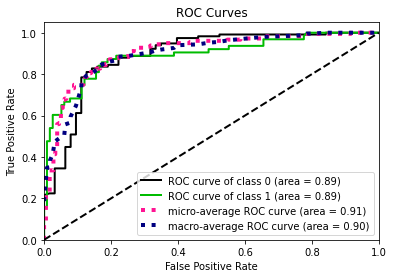

In [109]:
import scikitplot as skplt
import matplotlib.pyplot as plt

# Print the roc curve
predict_proba = logistic_model.predict_proba(x_val)
skplt.metrics.plot_roc_curve(y_val, predict_proba)
plt.show()

In [114]:
#  Print the AUC score
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val, predict_proba[::,1])
print("AUC score of logistic model is: ", auc)

AUC score of logistic model is:  0.8914203612479475


In [115]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Logistic model for kfold
kfold_logistic_model = LogisticRegression(max_iter=1000)
cv = KFold(n_splits=10, random_state=78, shuffle=True)
scores = cross_val_score(kfold_logistic_model, x_train, y_train, scoring='accuracy', cv=cv)

# Print performance
from numpy import mean
kfold_logistic_accuracy = mean(scores)
print('Accuracy of logistic model with kfold: ', kfold_logistic_accuracy)

Accuracy of logistic model with kfold:  0.7781690140845071


In [116]:
#  Comparision of logistic model vs logistic model with kfold
print('Logistic model vs logistic model with kfold')
print(base_logistic_accuracy, ' vs ', kfold_logistic_accuracy)

Logistic model vs logistic model with kfold
0.8324022346368715  vs  0.7781690140845071


In [118]:
# Logistic model
grid_search_logistic_base_model = LogisticRegression()

# Grid parameters
grid_params = dict()
grid_params['C'] = [0.01, 0.1, 1, 10, 100]
grid_params['penalty'] = ['l2']
grid_params['tol'] = [0.0001, 0.0002, 0.0003]
grid_params['max_iter'] = [1000, 2000, 3000]
grid_params['intercept_scaling'] = [1, 2, 3, 4]
grid_params['solver'] = ['liblinear', 'lbfgs']

grid_search_logistic_model = GridSearchCV(grid_search_logistic_base_model, grid_params, scoring='accuracy', cv=5)

grid_search_logistic_model.fit(x_train, y_train)

grid_search_best_parameters = grid_search_logistic_model.best_params_
grid_search_best_score = grid_search_logistic_model.best_score_

print('Parameters of best model for grid search: ', grid_search_best_parameters)
print('Accuracy of grid search logistic model: ', grid_search_best_score)

Parameters of best model for grid search:  {'C': 0.1, 'intercept_scaling': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Accuracy of grid search logistic model:  0.783689549886733


In [119]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Logistic model
random_search_base_model = LogisticRegression()

# Random Search Parameters
rs_params = dict()
rs_params['C'] = [uniform.rvs(loc=0, scale=2)]
rs_params['penalty'] = ['l2', 'l1']
rs_params['tol'] = [0.0001, 0.0002, 0.0003]
rs_params['max_iter'] = [1000, 2000, 3000]
rs_params['intercept_scaling'] = [1, 2, 3, 4]
rs_params['solver'] = ['liblinear']

rs_logistic_model = RandomizedSearchCV(random_search_base_model, rs_params, scoring='accuracy', cv=5)

rs_logistic_model.fit(x_train, y_train)

rs_best_parameters = rs_logistic_model.best_params_
rs_best_score = rs_logistic_model.best_score_

print('Parameters of best model for random search: ', rs_best_parameters)
print('Accuracy of random search logistic model: ', rs_best_score)

Parameters of best model for random search:  {'tol': 0.0002, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 3000, 'intercept_scaling': 3, 'C': 1.7606999721303296}
Accuracy of random search logistic model:  0.7766571456712301


In [122]:
from sklearn.metrics import precision_score

# Precision of base logistic model
logistic_pred = logistic_model.predict(x_val)
print('Precision of base logistic model', precision_score(y_val, logistic_pred))

# Precision of grid search logistic model
gs_logistic_pred = grid_search_logistic_model.predict(x_val)
print('Precision of grid search logistic model', precision_score(y_val, gs_logistic_pred))

# Precision of random search logistic model
rs_logistic_pred = rs_logistic_model.predict(x_val)
print('Precision of random search logistic model', precision_score(y_val, rs_logistic_pred))

Precision of base logistic model 0.7323943661971831
Precision of grid search logistic model 0.746268656716418
Precision of random search logistic model 0.7323943661971831


In [123]:
from sklearn.metrics import recall_score

# Recall of base logistic model
print('Recall of base logistic model', recall_score(y_val, logistic_pred))

# Recall of grid search logistic model
print('Recall of grid search logistic model', recall_score(y_val, gs_logistic_pred))

# Recall of random search logistic model
print('Recall of random search logistic model', recall_score(y_val, rs_logistic_pred))

Recall of base logistic model 0.8253968253968254
Recall of grid search logistic model 0.7936507936507936
Recall of random search logistic model 0.8253968253968254


In [124]:
from sklearn.metrics import f1_score

# F1 Score of base logistic model
print('F1 Score of base logistic model', f1_score(y_val, logistic_pred))

# F1 Score of grid search logistic model
print('F1 Score of grid search logistic model', f1_score(y_val, gs_logistic_pred))

# F1 Score of random search logistic model
print('F1 Score of random search logistic model', f1_score(y_val, rs_logistic_pred))

F1 Score of base logistic model 0.7761194029850745
F1 Score of grid search logistic model 0.7692307692307693
F1 Score of random search logistic model 0.7761194029850745


In [127]:
# Micro Average Precision of base logistic model
print('Micro Average Precision of base logistic model', precision_score(y_val, logistic_pred, average='micro'))

# Micro Average Precision of grid search logistic model
print('Micro Average Precision of grid search logistic model', precision_score(y_val, gs_logistic_pred, average='micro'))

# Micro Average Precision of random search logistic model
print('Micro Average Precision of random search logistic model', precision_score(y_val, rs_logistic_pred, average='micro'))

# Micro Average Recall of base logistic model
print('Micro Average Recall of base logistic model', recall_score(y_val, logistic_pred, average='micro'))

# Micro Average Recall of grid search logistic model
print('Micro Average Recall of grid search logistic model', recall_score(y_val, gs_logistic_pred, average='micro'))

# Micro Average Recall of random search logistic model
print('Micro Average Recall of random search logistic model', recall_score(y_val, rs_logistic_pred, average='micro'))

# Micro Average F1 Score of base logistic model
print('Micro Average F1 Score of base logistic model', f1_score(y_val, logistic_pred, average='micro'))

# Micro Average F1 Score of grid search logistic model
print('Micro Average F1 Score of grid search logistic model', f1_score(y_val, gs_logistic_pred, average='micro'))

# Micro Average F1 Score of random search logistic model
print('Micro Average F1 Score of random search logistic model', f1_score(y_val, rs_logistic_pred, average='micro'))

Micro Average Precision of base logistic model 0.8324022346368715
Micro Average Precision of grid search logistic model 0.8324022346368715
Micro Average Precision of random search logistic model 0.8324022346368715
Micro Average Recall of base logistic model 0.8324022346368715
Micro Average Recall of grid search logistic model 0.8324022346368715
Micro Average Recall of random search logistic model 0.8324022346368715
Micro Average F1 Score of base logistic model 0.8324022346368715
Micro Average F1 Score of grid search logistic model 0.8324022346368715
Micro Average F1 Score of random search logistic model 0.8324022346368715


In [128]:
# Macro Average Precision of base logistic model
print('Macro Average Precision of base logistic model', precision_score(y_val, logistic_pred, average='macro'))

# Macro Average Precision of grid search logistic model
print('Macro Average Precision of grid search logistic model', precision_score(y_val, gs_logistic_pred, average='macro'))

# Macro Average Precision of random search logistic model
print('Macro Average Precision of random search logistic model', precision_score(y_val, rs_logistic_pred, average='macro'))

# Macro Average Recall of base logistic model
print('Macro Average Recall of base logistic model', recall_score(y_val, logistic_pred, average='macro'))

# Macro Average Recall of grid search logistic model
print('Macro Average Recall of grid search logistic model', recall_score(y_val, gs_logistic_pred, average='macro'))

# Macro Average Recall of random search logistic model
print('Macro Average Recall of random search logistic model', recall_score(y_val, rs_logistic_pred, average='macro'))

# Macro Average F1 Score of base logistic model
print('Macro Average F1 Score of base logistic model', f1_score(y_val, logistic_pred, average='macro'))

# Macro Average F1 Score of grid search logistic model
print('Macro Average F1 Score of grid search logistic model', f1_score(y_val, gs_logistic_pred, average='macro'))

# Macro Average F1 Score of random search logistic model
print('Macro Average F1 Score of random search logistic model', f1_score(y_val, rs_logistic_pred, average='macro'))

Macro Average Precision of base logistic model 0.8152712571726657
Macro Average Precision of grid search logistic model 0.8150986140724947
Macro Average Precision of random search logistic model 0.8152712571726657
Macro Average Recall of base logistic model 0.8308018609742747
Macro Average Recall of grid search logistic model 0.8235495347564312
Macro Average Recall of random search logistic model 0.8308018609742747
Macro Average F1 Score of base logistic model 0.8210954157782515
Macro Average F1 Score of grid search logistic model 0.8188259109311742
Macro Average F1 Score of random search logistic model 0.8210954157782515


In [129]:
# Weighted Average Precision of base logistic model
print('Weighted Average Precision of base logistic model', precision_score(y_val, logistic_pred, average='weighted'))

# Weighted Average Precision of grid search logistic model
print('Weighted Average Precision of grid search logistic model', precision_score(y_val, gs_logistic_pred, average='weighted'))

# Weighted Average Precision of random search logistic model
print('Weighted Average Precision of random search logistic model', precision_score(y_val, rs_logistic_pred, average='weighted'))

# Weighted Average Recall of base logistic model
print('Weighted Average Recall of base logistic model', recall_score(y_val, logistic_pred, average='weighted'))

# Weighted Average Recall of grid search logistic model
print('Weighted Average Recall of grid search logistic model', recall_score(y_val, gs_logistic_pred, average='weighted'))

# Weighted Average Recall of random search logistic model
print('Weighted Average Recall of random search logistic model', recall_score(y_val, rs_logistic_pred, average='weighted'))

# Weighted Average F1 Score of base logistic model
print('Weighted Average F1 Score of base logistic model', f1_score(y_val, logistic_pred, average='weighted'))

# Weighted Average F1 Score of grid search logistic model
print('Weighted Average F1 Score of grid search logistic model', f1_score(y_val, gs_logistic_pred, average='weighted'))

# Weighted Average F1 Score of random search logistic model
print('Weighted Average F1 Score of random search logistic model', f1_score(y_val, rs_logistic_pred, average='weighted'))

Weighted Average Precision of base logistic model 0.8398102248916632
Weighted Average Precision of grid search logistic model 0.8354784338483162
Weighted Average Precision of random search logistic model 0.8398102248916632
Weighted Average Recall of base logistic model 0.8324022346368715
Weighted Average Recall of grid search logistic model 0.8324022346368715
Weighted Average Recall of random search logistic model 0.8324022346368715
Weighted Average F1 Score of base logistic model 0.8344123357672929
Weighted Average F1 Score of grid search logistic model 0.8335105059597856
Weighted Average F1 Score of random search logistic model 0.8344123357672929
